In [89]:
import os.path
import sys

import os

# Récupère le chemin d'accès parent de sys.path[0]
parent_dir = os.path.dirname(sys.path[0])

sys.path.append(os.path.abspath(parent_dir))
import importlib
import algorithmes
importlib.reload(algorithmes)
from algorithmes import *
import random
import mesa

## L'implimentation d'un systeme multi agent qui suit le Protocole AMI

## Création des Agents

In [90]:
class Recuit_sem(mesa.Agent):
    
    # Création d'agent Recuit simulé 


    def __init__(self, model,parameters):
        
        super().__init__(self,model)
        self.parameters = parameters
        self.history = []

    def execute(self):

        # Tirer une solution aléatoire du Pool et la remplacer par une solution améliorer par Recuit simulé
        solution_index = np.random.randint(len(self.model.Pool))
        new_solution, meilleure_valeur , _  = recuit_simule(self.model.Pool[solution_index],self.parameters['temperature_initiale'] , self.parameters['temperature_finale'],alpha=0.99)
        self.model.Pool[solution_index] = new_solution

            
    def step(self):
        
        self.execute()

In [91]:
class Tabou(mesa.Agent):
    
    # Création d'agent Tabou 

    def __init__(self,  model,parameters):
        super().__init__(self,model)
      
        self.parameters = parameters
        self.history = []
        self.initial_solution = None

    def execute(self):

        # Tirer une solution aléatoire du Pool et la remplacer par une solution améliorer par Tabou
        solution_index = np.random.randint(len(self.model.Pool))
        new_solution, meilleure_valeur , _ = tabou(self.model.Pool[solution_index] ,self.parameters['taille_tabou'],self.parameters['max_iterations'],self.parameters['n_voisin'])
        self.model.Pool[solution_index] = new_solution

            
    def step(self):
        self.execute()

In [92]:
class Genetic(mesa.Agent):
    
    # Création d'agent genetique 


    def __init__(self,  model,parameters):

        super().__init__(self,model)
        self.parameters = parameters


    def execute(self):

        # Prendre le Pool comme une population initial et la remplacer par une population améliorer par l'algo genetique
        new_solution, meilleure_valeur , _ ,population = genetique(self.model.Pool,self.parameters['taux_mutation'],self.parameters['max_iterations'])
        self.model.Pool = copy.deepcopy(population)

            
    def step(self):
        self.execute()

In [93]:
def compute_Pool_avg(model):
    
    # Calculer le cout moyenne des solutions dans le Pool
    couts = [cout(get_route_version2(model.Pool[i], time_window, Q)) for i in range(len(model.Pool))]
    return sum(couts)/len(couts)

def compute_Pool_min(model):
    
    # Calculer le cout minimum des solution dans le Pool
    couts = [cout(get_route_version2(model.Pool[i], time_window, Q)) for i in range(len(model.Pool))]

    return min(couts)

def get_the_best_solution(model):

    # Récupérer la meilleur solution dans le Pool
    couts = np.array([cout(get_route_version2(model.Pool[i], time_window, Q)) for i in range(len(model.Pool))])

    return model.Pool[np.argmin(couts)]

In [124]:
## Les paramètres des Algorithmes 
num_clients = 100
parameters = {'rs' : {'temperature_initiale' : 1  , 'temperature_finale' : 1e-6 } , 'tabou' : {'taille_tabou' : num_clients , 'max_iterations' : 100 , 'n_voisin' : 2} , 'genetic'  : {'taux_mutation' : 0.2 ,'max_iterations' : 200 }}

In [125]:
class SMA(mesa.Model):
    
    """Création d'environnement de communication entre les agents"""


    def __init__(self,Pool,parameters):
        
        self.schedule = mesa.time.RandomActivation(self)
        self.Pool = Pool
        

        # Instanciation des agents 
        self.optimazers = [Recuit_sem(self,parameters['rs']),Tabou(self,parameters['tabou'])]
        self.genetique_optimizer = Genetic(self,parameters['genetic'])

        for agent in self.optimazers : 
            self.schedule.add(agent)

        ## Récuperer à chaque step la meilleur solution dans le Pool et son cout
        self.datacollector = mesa.DataCollector(
            model_reporters={"pool_avg": compute_Pool_avg ,"best_pool": get_the_best_solution,"pool_min": compute_Pool_min } )


    def step(self):

        self.datacollector.collect(self)
        self.schedule.step()


In [126]:
## Création du Pool
Pool = []
list_client_initial = [i for i in range(num_clients)]
for j in range(10): 
    x  = copy.deepcopy(list_client_initial)
    random.shuffle(x)
    Pool.append(x)

In [127]:
sma_env = SMA(Pool,parameters)

In [140]:
for i in range(100):

    # Amélioration de chaque solution par les algo Tabou / Récuit simuler
    sma_env.step()

    if i%10 == 1 :
    
                # Amélioration du Pool par l'algo genetique
                sma_env.genetique_optimizer.execute()
                sma_env.datacollector.collect(sma_env)
    

In [141]:
agent_wealth = sma_env.datacollector.get_model_vars_dataframe()

Text(0, 0.5, 'Le cout du meilleur element dans le Pool')

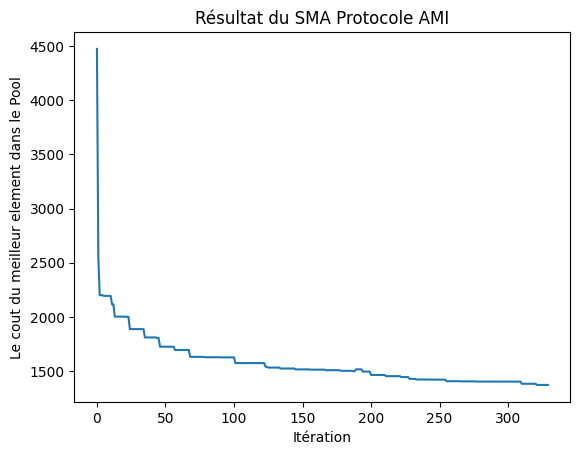

In [142]:
plt.plot(agent_wealth['pool_min'])
plt.title("Résultat du SMA Protocole AMI")
plt.xlabel("Itération")
plt.ylabel("Le cout du meilleur element dans le Pool")
#plt.savefig('Résultat_sma_ami1')

In [143]:
print('The best solution is :' ,get_route_version2(get_the_best_solution(sma_env),time_window,Q))
print('With the cost :' , cout(get_route_version2(get_the_best_solution(sma_env),time_window,Q)))
print('The number of vehicle :' ,len(get_route_version2(get_the_best_solution(sma_env),time_window,Q)))

The best solution is : [[61, 4, 14, 89, 57, 44, 79, 21, 72, 99, 59, 27, 58, 5, 64, 53, 0, 45, 32, 25, 76, 81, 66, 8, 12, 55, 97, 92, 47, 83], [16, 50, 31, 29, 73, 70, 39, 82, 86, 90, 60, 6, 33, 77, 23, 41, 74, 28, 38, 36, 51, 43, 65, 85, 22, 69, 35, 7, 95, 19], [18, 98, 37, 1, 9, 15, 68, 46, 48, 34, 91, 78, 3, 88, 67, 84, 11, 13, 87, 10, 71, 49, 2, 17, 56, 93, 96, 30], [42, 80, 62, 26, 54, 40, 63, 75, 24, 94, 52, 20]]
With the cost : 1370.9695220991784
The number of vehicle : 4


In [144]:
print('The best solution is :' ,get_route_version2(get_the_best_solution(sma_env),time_window,Q))
print('With the cost :' , cout(get_route_version2(get_the_best_solution(sma_env),time_window,Q)))
print('The number of vehicle :' ,len(get_route_version2(get_the_best_solution(sma_env),time_window,Q)))

The best solution is : [[61, 4, 14, 89, 57, 44, 79, 21, 72, 99, 59, 27, 58, 5, 64, 53, 0, 45, 32, 25, 76, 81, 66, 8, 12, 55, 97, 92, 47, 83], [16, 50, 31, 29, 73, 70, 39, 82, 86, 90, 60, 6, 33, 77, 23, 41, 74, 28, 38, 36, 51, 43, 65, 85, 22, 69, 35, 7, 95, 19], [18, 98, 37, 1, 9, 15, 68, 46, 48, 34, 91, 78, 3, 88, 67, 84, 11, 13, 87, 10, 71, 49, 2, 17, 56, 93, 96, 30], [42, 80, 62, 26, 54, 40, 63, 75, 24, 94, 52, 20]]
With the cost : 1370.9695220991784
The number of vehicle : 4


In [145]:
import folium

def tracer_segments_folium(L,color,m):
    # Créer une carte centrée sur le premier point de la liste

    # Ajouter des marqueurs pour chaque point de la liste
    for c in L:

        folium.Marker(location=c).add_to(m)

    # Ajouter une Polyline reliant les marqueurs
    folium.PolyLine(locations=L, color=color).add_to(m)

    # Afficher la carte


def plot_solution(solution):

    m = folium.Map(location=(0,0), zoom_start=12)
    K = len(solution)
    k = 0
    color = ['red' , 'blue' , 'green', 'yellow']
    for vehicule in solution : 

        L = [(data_client_index['CUSTOMER_LATITUDE'].iloc[k] , data_client_index['CUSTOMER_LONGITUDE'].iloc[k]) for k in range(len(vehicule))]
        tracer_segments_folium(L,color[k],m)
        k = k + 1
    m.save('solution_ploted_test.html')


In [146]:
plot_solution(get_route_version2(get_the_best_solution(sma_env),time_window,Q))